In [1]:
import cv2
import os
import numpy as np
from PIL import Image
import skimage
from skimage.metrics import structural_similarity
from skimage import data, draw, io


In [2]:
#reads in video to init_video
with open("dataset/Videos/data_test1.rgb", "rb") as f:
    v = np.fromfile(f, np.dtype('B'))
#setting the number of pixels in frame
pxct = 129600
#setting the number of frames
frct = (int)(v.size/(3*pxct))
init_video = []
for frame_number in range(frct):
        start = (frame_number) * pxct * 3
        curr_frame = v[start:start + 3 * pxct]
        final_frame = np.reshape(curr_frame, (480,270,3), order = 'F')
        final_frame = np.rot90(final_frame,3)
        final_frame = np.flip(final_frame,1)
        
        #searching these final frames for logos (new cell)
        init_video.append(final_frame)

In [3]:
#generate cuts for advertisement
advert_frames = []
for frame_number in range(frct - 1):
    #calculate new shots with histogram
    #less means more similar
    hist1 = cv2.calcHist([init_video[frame_number]],[0],None,[256],[0,256])
    hist2 = cv2.calcHist([init_video[frame_number + 1]],[0],None,[256],[0,256])
    score=cv2.compareHist(hist1,hist2,cv2.HISTCMP_BHATTACHARYYA)
    #store score for ssi
    #less means more similar
    #i1 = cv2.cvtColor(init_video[frame_number], cv2.COLOR_BGR2GRAY)
    #i2 = cv2.cvtColor(init_video[frame_number + 1], cv2.COLOR_BGR2GRAY)
    #score2 = structural_similarity(i1, i2)
    #score2 = 1-score2 
    #frame_stats[frame_number][1] = score2
    
    #score indicates sensitivity for shot changes
    if score > 0.3:
        advert_frames.append(frame_number)
        advert_frames.append(frame_number+1)
        #saves the image, currently used for debugging
        #if score + score2 > 0.3:
        data = Image.fromarray(init_video[frame_number]).convert('RGB')
        data.save('images_cut/{}.png'.format(frame_number))
        data = Image.fromarray(init_video[frame_number+1]).convert('RGB')
        data.save('images_cut/{}.png'.format(frame_number+1))
#save beginning and end of cuts in number of frames
#storing the advertisements to replace with
#indexed the same way as that of cuts_begin and cuts_end
#if not to be replaced, a blank line
replaced_advertisements = []
cuts_begin = []
cuts_end = []
for i in range(len(advert_frames)):
    for j in range(i,len(advert_frames)):
        if advert_frames[j] - advert_frames[i] == 449:
            cuts_begin.append(advert_frames[i])
            cuts_end.append(advert_frames[j])

In [4]:
#image negatives for training
# for f in range(frct - 1):
#     if f > 3000 or f < 1200:
#         data = Image.fromarray(init_video[f]).convert('RGB')
#         data.save('negative_images/{}.png'.format(f))

In [5]:
#reading in all other advertisements
#saves in a dictionary with first part assumed to be the company name
advertisements = {}
PATHS_TO_ADVERTISEMENTS = "dataset/Ads"
for file in os.listdir(PATHS_TO_ADVERTISEMENTS):
    filename = os.fsdecode(file)
    if filename.endswith(".rgb"): 
        vpath = os.path.join(PATHS_TO_ADVERTISEMENTS, filename)
        with open(vpath, "rb") as f:
            v = np.fromfile(f, np.dtype('B'))
        #setting the number of pixels in frame
        pxct = 129600
        #setting the number of frames
        frct = (int)(v.size/(3*pxct))
        video = []
        for frame_number in range(frct):
            start = (frame_number) * pxct * 3
            curr_frame = v[start:start + 3 * pxct]
            final_frame = np.reshape(curr_frame, ( 480,270, 3), order = 'F')
            final_frame = np.rot90(final_frame,3)
            final_frame = np.flip(final_frame,1)
            video.append(final_frame)
        #Get the name of the company
        key = filename.split('_')[0]
        advertisements[key] = video
        
print(advertisements.keys())
    

dict_keys(['Starbucks', 'Subway'])


In [6]:
#splicing in videos with the names 
#save beginning and end of cuts in number of frames
cuts_begin = [2400]
cuts_end = [2849]
#storing the advertisements to replace with
#indexed the same way as that of cuts_begin and cuts_end
#if not to be replaced, an empty string
replaced_advertisements = ["Subway"]
final_video = []
for i in range (len(cuts_begin)):
    if i == 0:
        final_video = init_video[:cuts_begin[i]] + advertisements[replaced_advertisements[i]] + init_video[cuts_end[i]:]
    else:
        #further work required to sync frames iff ad lengths are variable
        final_video = final_video[:cuts_begin[i]] + advertisements[replaced_advertisements[i]] + final_video[cuts_end[i]:]
        

In [50]:
#experimenting with SIFT
#finding points and comparing across image 
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
#returns boolean if logo of logo_path is recognized in frame
def logo_recognition(frame, logo):
    #read in logo 
    graylogo = cv2.cvtColor(logo, cv2.COLOR_BGR2GRAY)

# #change to grayscale
    grayframe = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    sift = cv2.SIFT_create()

    logopoints, logodescriptors = sift.detectAndCompute(graylogo, None)
    framepoints, framedescriptors = sift.detectAndCompute(grayframe, None)
    
    #print(logopoints)

    #bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
    bf = cv2.BFMatcher()

    #matches = bf.match(logodescriptors,framedescriptors)
    matches = bf.knnMatch(logodescriptors,framedescriptors, k=2)

#matches = sorted(matches, key = lambda x:x.distance)

    # Apply ratio test
    good_points = []
    good_points_nolist = []
    for m,n in matches:
        if m.distance < 0.69*n.distance:
            good_points.append([m])
            good_points_nolist.append(m)
    #print(good_points)

# cv2.drawMatchesKnn expects list of lists as matches.
    #img3 = cv2.drawMatchesKnn(logo, logopoints, frame, framepoints, good_points, None,
                              #matchColor=(0, 255, 0), matchesMask=None,
                              #singlePointColor=(255, 0, 0), flags=0)
    start_point = (5, 5)
    end_point = (220, 220)
    color = (255, 0, 0)
    thickness = 2

    list_kp1 = []
    list_framepoints = []

# For each match...
    for mat in good_points_nolist:

    # Get the matching keypoints for each of the images
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx

    # x - columns
    # y - rows
    # Get the coordinates
        (x1, y1) = logopoints[img1_idx].pt
        (x2, y2) = framepoints[img2_idx].pt

    # Append to each list
        #list_kp1.append((x1, y1))
        list_framepoints.append((x2, y2))
        
        #cv2.imshow('images/box-1.png', img)
        data = Image.fromarray(frame).convert('RGB')
        #print(data)
        #convert rgb frame to png for writing
        data.save('images/box-test.png'.format(1));
        #get new saved png frame
        
    if(len(list_framepoints) > 0):
        average = len(list_framepoints);
        x=0;
        y=0;
        for pt in list_framepoints: 
            x = x+pt[0]
            y = y+pt[1] 
        
        x_average = x/average
        y_average = y/average
        #for point in list_kp2:
        #row, col = draw.rectangle(start=list_kp2[0], end=list_kp2[1])
        #print(row, col)
        #print(point)
        #pt1 = list(list_kp2[0])
        #pt2 = list(list_kp2[1])
        #print(pt1, pt2)
        img = cv2.imread('images/box-test.png')
        center_coordinates = (x_average, y_average)
        radius = 5
        color = (0, 255, 0)
        thickness = 4
        image = cv2.circle(img, (100, 100), radius, color, thickness)
        plt.imshow(image)

    return (len(good_points) > 7)

In [51]:
#creating transform matrix to draw binding box
#     good_points = matches[:10]
    
    
#     src_pts = np.float32([ logopoints[m.queryIdx].pt for m in good_points]).reshape(-1,1,2)
#     dst_pts = np.float32([ framepoints[m.trainIdx].pt for m in good_points]).reshape(-1,1,2)
#     M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
#     matchesMask = mask.ravel().tolist()
#     h,w = logo.shape[:2]
#     pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

#     dst = cv2.perspectiveTransform(pts,M)
#     dst += (w, 0)  # adding offset

#     draw_params = dict(matchColor = (0,255,0), # draw matches in green color
#                singlePointColor = None,
#                matchesMask = matchesMask, # draw only inliers
#                flags = 2)

#     img3 = cv2.drawMatches(logo,logopoints,frame1,framepoints,good_points, None,**draw_params)

# # Draw bounding box in Red
#     img3 = cv2.polylines(img3, [np.int32(dst)], True, (0,0,255),3, cv2.LINE_AA)

#     cv2.imshow("result", img3)
#cv2.waitKey()
# or another option for display output
#plt.imshow(img3, 'result'), plt.show(

starbucks


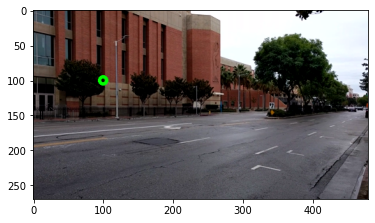

In [52]:
logo_names = ["subway", "starbucks"]
logos = []
for l in logo_names:
    logos.append(plt.imread('Dataset/Brand Images/{company}_logo.bmp'.format(company = l)))
    
#for all the beginning cut sections
for k in range(len(cuts_begin)):
    loopstart = 0
    if not k == 0:
        loopstart = cuts_end[k-1]
    
    #for all the frames before the cut
    for j in range(loopstart,cuts_begin[k],10):
        
        #format each image
        img = np.flip(final_video[j],axis = 2)
        
        tobreak = False
        for logo in range(len(logos)):
            if(logo_recognition(img,logos[logo])):
                replaced_advertisements.append(logo_names[logo])
                print(logo_names[logo])
                tobreak = True
                break
        if tobreak:
            break
#print(replaced_advertisements)                

In [17]:
#saves data for java to cut audio
ad_times = open("ad_times.txt", "w")
for i in range(len(replaced_advertisements)):
    ad_times.write(replaced_advertisements[i] + " " + str(cuts_begin[i]) + "\n")
ad_times.close()

IndexError: list index out of range

In [ ]:
#add function to find points and draw the box for each frame in the video
#output video to rgb
#
with open('output.rgb', "wb") as f:
    for p in final_video:
        output_frame = np.ravel(np.split(p, 3, axis = 2), order = 'C')
        f.write (bytes(output_frame))
f.close()

In [ ]:
#output avi for debugging
out = cv2.VideoWriter('video.avi', cv2.VideoWriter_fourcc(*'DIVX'), 30, (480, 270))
for i in range(len(final_video)):
    out.write(final_video[i])
out.release()